In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [2]:
df = pd.read_csv('skillfactory_rds4_sql_v3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            118 non-null    int64  
 1   flight_no            118 non-null    object 
 2   departure_airport    118 non-null    object 
 3   arrival_airport      118 non-null    object 
 4   actual_departure     118 non-null    object 
 5   actual_arrival       118 non-null    object 
 6   flight_time          118 non-null    float64
 7   model                118 non-null    object 
 8   booking_sum          118 non-null    float64
 9   number_of_passenger  118 non-null    int64  
 10  economy              118 non-null    int64  
 11  businees             118 non-null    int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 11.2+ KB


In [4]:
def seats(model):
    if model == 'Boeing 737-300':
        return 130
    else:
        return 97
    
def eco_seats(model):
    if model == 'Boeing 737-300':
        return 118
    else:
        return 85
    
def busi_seats(model):
    if model == 'Boeing 737-300':
        return 12
    else:
        return 12    

Поработаем с колонками о кол-ве мест в самолетах и сделаем новые признаки по заполнению борта

In [5]:
df['seats_count'] = df['model'].apply(seats)
df['eco_seats'] = df['model'].apply(eco_seats)
df['busi_seats'] = df['model'].apply(busi_seats)
df['empty_seats'] = df['seats_count'] - df['number_of_passenger']

In [6]:
df['booking_sum'].mean()

5505956.779661017

В среднем, билеты на рейс стоят 5.5 млн

Посмотрим на распределение стоимости билетов для каждого рейса

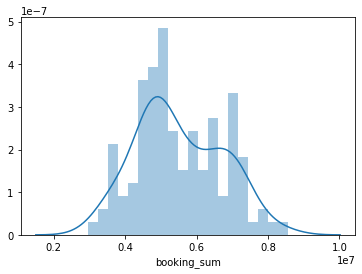

In [7]:
sns.distplot(df['booking_sum'], bins=20)

По графику видно, что стоимость всех билетов на рейс, в большинстве случаев составляет 4.5-5 млн. что ниже средней стоимости билетов на рейс. Так же видим, что у достаточного кол-ва рейсов стоимость всех билетов ниже 4млн. Но и с сдругой стороны видно, что есть рейсы, где стоимость билетов выше 6 млн.

Попробуем оценить, как это связано с загруженностью самолета

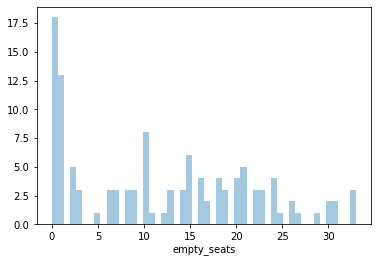

In [8]:
sns.distplot(df['empty_seats'], bins=50, kde=False)

По графику мы видим, что большая часть самолетов загружена почти полностью. Но так же и имеются рейсы, где очень много пустых мест (больше 20). Будем брать статистику, что если рейс заполнен меньше чем на 75% то он считается нерентабельным

In [9]:
df['filling_plane_%'] = df['number_of_passenger']*100 / df['seats_count']

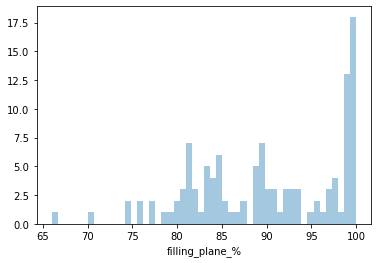

In [10]:
sns.distplot(df['filling_plane_%'], bins=50, kde=False)

In [11]:
df[df['filling_plane_%'] < 75]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%
2,136122,PG0252,AAQ,SVO,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.0,Boeing 737-300,5411400.0,97,87,10,130,118,12,33,74.615385
38,136360,PG0252,AAQ,SVO,2017-02-05T10:08:00Z,2017-02-05T11:48:00Z,100.0,Boeing 737-300,5468500.0,97,86,11,130,118,12,33,74.615385
68,136642,PG0480,AAQ,EGO,2017-01-30T09:28:00Z,2017-01-30T10:17:00Z,49.0,Sukhoi Superjet-100,2965000.0,64,54,10,97,85,12,33,65.979381
93,136807,PG0480,AAQ,EGO,2017-02-23T09:28:00Z,2017-02-23T10:18:00Z,50.0,Sukhoi Superjet-100,3313200.0,68,60,8,97,85,12,29,70.103093


Отсюда мы видим, что по нашей оценке есть 4 нерентабельных рейса. 
- Интересно, бизнес-класс заполнен на всех рейсах почти на 100%
- Так же рейсы в Москву заполнены немного меньше 75%, и с условностьями их можно отнести к рентабельным, так же у них прибыль почти на уровне среднего значения.

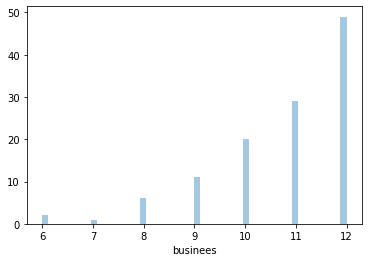

In [12]:
sns.distplot(df['businees'], bins=50, kde=False)

Кол-во проданных билетов в бизнес-класс. Видно, что половина мест в бизнес-классе всегда куплена, а в большинстве случаев это больше 10 мест в рейсе

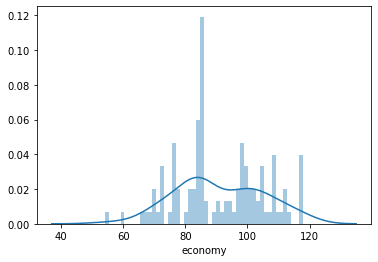

In [13]:
sns.distplot(df['economy'], bins=50)

В среднем на рейсы продают от 80 до 100 билетов в эконом-класс

Теперь посчитаем чистую прибыль для каждого рейса, для этого нам нужно узнать расходы для каждого перелета.
Возьмем расход топлива для каждой модели самолета и посчитаем сколько его уходит на перелет. 

- Для боинга возьмем значение расхода топлива 2600 кг/ч
- Для СуперДжета 1670 кг/ч
- Цена топлива за тонну в 2017 в Анапе составляла 42674 руб

In [14]:
def flight_consumption(model, flight_time):
    '''Функция возвращает расходы на топливо для каждого рейса'''
    if model == 'Boeing 737-300':
        return round((flight_time * (2600 / 60)) * 42.674, 1)
    else:
        return round((flight_time * (1670 / 60)) * 42.674, 1)
df['consumption'] = df.apply(lambda x: flight_consumption(x['model'], x['flight_time']), axis=1)

In [15]:
df['income'] = df['booking_sum'] - df['consumption']

In [16]:
df['income'].mean()

5383908.823728812

В итоге средний доход составил чуть больше 5млн. Здесь мы не учли и другие расходы, такие как содержание самолета, стоянка, оклады сотрудников и тд. 

Теперь посчитаем средний доход для каждого направления, те в Москву и в Белгород. Так же есть рейсы и в Новокузнецк, но по этим рейсам данные отсутсвуют, поэтому проводим анализ без этого направления.

In [17]:
df['income'][df['model'] == 'Boeing 737-300'].mean()

6290467.300000003

In [18]:
df['income'][df['model'] == 'Sukhoi Superjet-100'].mean()

4477350.347457629

Посмотрим на рейсы, где прибыль ниже среднего для этих направлений

In [19]:
df[(df['model'] == 'Sukhoi Superjet-100') & (df['income'] < df['income'][df['model'] == 'Sukhoi Superjet-100'].mean()) & (df['filling_plane_%'] < 75)]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income
68,136642,PG0480,AAQ,EGO,2017-01-30T09:28:00Z,2017-01-30T10:17:00Z,49.0,Sukhoi Superjet-100,2965000.0,64,54,10,97,85,12,33,65.979381,58200.2,2906799.8
93,136807,PG0480,AAQ,EGO,2017-02-23T09:28:00Z,2017-02-23T10:18:00Z,50.0,Sukhoi Superjet-100,3313200.0,68,60,8,97,85,12,29,70.103093,59388.0,3253812.0


У этих 2 рейсов низкая прибыль. Возможно для этих рейсов лучше использовать самолеты с меньшим кол-вом посадочных мест, либо наоборот использовать более вместительный самолет, но вместо полетов каждый день сделать полеты каждые 2 дня.

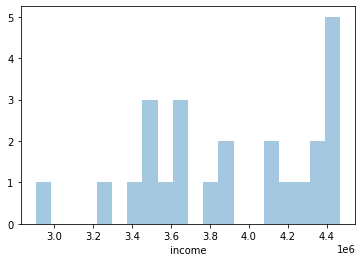

In [20]:
sns.distplot(df['income'][(df['model'] == 'Sukhoi Superjet-100') &\
                          (df['income'] < df['income'][df['model'] == 'Sukhoi Superjet-100'].mean())], bins=20, kde=False)

In [21]:
df[(df['model'] == 'Sukhoi Superjet-100') & (df['income'] < 4000000)]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income
63,136609,PG0480,AAQ,EGO,2017-01-08T09:28:00Z,2017-01-08T10:18:00Z,50.0,Sukhoi Superjet-100,3735000.0,81,71,10,97,85,12,16,83.505155,59388.0,3675612.0
65,136620,PG0480,AAQ,EGO,2017-02-17T09:30:00Z,2017-02-17T10:19:00Z,49.0,Sukhoi Superjet-100,3854500.0,79,70,9,97,85,12,18,81.443299,58200.2,3796299.8
68,136642,PG0480,AAQ,EGO,2017-01-30T09:28:00Z,2017-01-30T10:17:00Z,49.0,Sukhoi Superjet-100,2965000.0,64,54,10,97,85,12,33,65.979381,58200.2,2906799.8
77,136678,PG0480,AAQ,EGO,2017-01-28T09:27:00Z,2017-01-28T10:17:00Z,50.0,Sukhoi Superjet-100,3657300.0,80,70,10,97,85,12,17,82.474227,59388.0,3597912.0
87,136767,PG0480,AAQ,EGO,2017-01-23T09:27:00Z,2017-01-23T10:18:00Z,51.0,Sukhoi Superjet-100,3976600.0,83,73,10,97,85,12,14,85.567010,60575.7,3916024.3
93,136807,PG0480,AAQ,EGO,2017-02-23T09:28:00Z,2017-02-23T10:18:00Z,50.0,Sukhoi Superjet-100,3313200.0,68,60,8,97,85,12,29,70.103093,59388.0,3253812.0
98,136838,PG0480,AAQ,EGO,2017-01-24T09:30:00Z,2017-01-24T10:21:00Z,51.0,Sukhoi Superjet-100,3747800.0,86,76,10,97,85,12,11,88.659794,60575.7,3687224.3
100,136844,PG0480,AAQ,EGO,2017-02-28T09:26:00Z,2017-02-28T10:16:00Z,50.0,Sukhoi Superjet-100,3720700.0,79,73,6,97,85,12,18,81.443299,59388.0,3661312.0
107,136887,PG0480,AAQ,EGO,2017-01-20T09:30:00Z,2017-01-20T10:19:00Z,49.0,Sukhoi Superjet-100,3546600.0,78,70,8,97,85,12,19,80.412371,58200.2,3488399.8
108,136888,PG0480,AAQ,EGO,2017-02-14T09:29:00Z,2017-02-14T10:19:00Z,50.0,Sukhoi Superjet-100,3946300.0,79,69,10,97,85,12,18,81.443299,59388.0,3886912.0


In [22]:
136609, 136620, 136642, 136678, 136767, 136807, 136838, 136844, 136887, 136888, 136922, 136936, 136937

(136609,
 136620,
 136642,
 136678,
 136767,
 136807,
 136838,
 136844,
 136887,
 136888,
 136922,
 136936,
 136937)

По распределению видно, что всего 2 рейса, которые мы отметили выше имеют очень низкий доход. Так же есть рейсы, которые имееют доход на 1млн меньше среднего, что тоже достаточно много

Возможно эти рейсы тоже можно как-то оптимизировать, например, как предлагал выше

Посмотрим теперь тоже самое, но для Московского направления

In [23]:
df[(df['model'] == 'Boeing 737-300') & (df['income'] < df['income'][df['model'] == 'Boeing 737-300'].mean()) & (df['filling_plane_%'] < 75)]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income
2,136122,PG0252,AAQ,SVO,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.0,Boeing 737-300,5411400.0,97,87,10,130,118,12,33,74.615385,184920.7,5226479.3
38,136360,PG0252,AAQ,SVO,2017-02-05T10:08:00Z,2017-02-05T11:48:00Z,100.0,Boeing 737-300,5468500.0,97,86,11,130,118,12,33,74.615385,184920.7,5283579.3


По-большому счету эти 2 рейса можно назвать рентабельными. Так как заполненость почти 75%

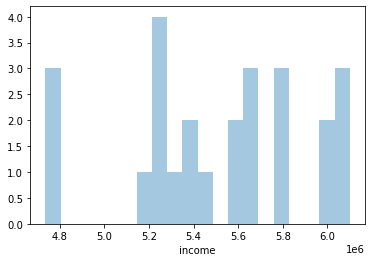

In [24]:
sns.distplot(df['income'][(df['model'] == 'Boeing 737-300') & \
                          (df['income'] < df['income'][df['model'] == 'Boeing 737-300'].mean())], bins=20, kde=False)

По распределению видим, что есть рейсы, где доходы значительно меньше среднего. Нужно их найти

In [25]:
df[(df['model'] == 'Boeing 737-300') & (df['income'] < 5000000)]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income
12,136178,PG0252,AAQ,SVO,2017-01-29T10:10:00Z,2017-01-29T11:49:00Z,99.0,Boeing 737-300,4918600.0,99,90,9,130,118,12,31,76.153846,183071.5,4735528.5
21,136250,PG0252,AAQ,SVO,2017-02-08T10:06:00Z,2017-02-08T11:47:00Z,101.0,Boeing 737-300,4951300.0,99,91,8,130,118,12,31,76.153846,186769.9,4764530.1
54,136464,PG0252,AAQ,SVO,2017-01-09T10:07:00Z,2017-01-09T11:47:00Z,100.0,Boeing 737-300,4936200.0,100,93,7,130,118,12,30,76.923077,184920.7,4751279.3


Видим, что эти рейсы хоть и заполнены больше 75%, но имееют доход гораздо меньше остальных рейсов. Скорее всего это из-за того, что на этот рейсы было продано меньше билетов в бизнес-класс, который составляет немалый процент дохода. Так же видим, что на этих рейсах кол-во пустых мест достаточно большое. 

Вот этом случае возможно уместнее использовать самолеты с меньшим кол-вом посадочных мест. Тем более, что в авиапарке есть СуперДжеты, которые лучше подойдут для этих рейсов 

In [26]:
df[(df['model'] == 'Boeing 737-300') & (df['number_of_passenger'] < 105)]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,economy,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income
2,136122,PG0252,AAQ,SVO,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.0,Boeing 737-300,5411400.0,97,87,10,130,118,12,33,74.615385,184920.7,5226479.3
12,136178,PG0252,AAQ,SVO,2017-01-29T10:10:00Z,2017-01-29T11:49:00Z,99.0,Boeing 737-300,4918600.0,99,90,9,130,118,12,31,76.153846,183071.5,4735528.5
14,136185,PG0252,AAQ,SVO,2017-01-14T10:06:00Z,2017-01-14T11:49:00Z,103.0,Boeing 737-300,5435700.0,104,94,10,130,118,12,26,80.000000,190468.3,5245231.7
15,136202,PG0252,AAQ,SVO,2017-01-05T10:07:00Z,2017-01-05T11:49:00Z,102.0,Boeing 737-300,5395800.0,100,89,11,130,118,12,30,76.923077,188619.1,5207180.9
21,136250,PG0252,AAQ,SVO,2017-02-08T10:06:00Z,2017-02-08T11:47:00Z,101.0,Boeing 737-300,4951300.0,99,91,8,130,118,12,31,76.153846,186769.9,4764530.1
38,136360,PG0252,AAQ,SVO,2017-02-05T10:08:00Z,2017-02-05T11:48:00Z,100.0,Boeing 737-300,5468500.0,97,86,11,130,118,12,33,74.615385,184920.7,5283579.3
39,136366,PG0252,AAQ,SVO,2017-01-11T10:08:00Z,2017-01-11T11:47:00Z,99.0,Boeing 737-300,6265600.0,103,92,11,130,118,12,27,79.230769,183071.5,6082528.5
45,136420,PG0252,AAQ,SVO,2017-01-01T10:09:00Z,2017-01-01T11:47:00Z,98.0,Boeing 737-300,6531100.0,104,93,11,130,118,12,26,80.000000,181222.3,6349877.7
54,136464,PG0252,AAQ,SVO,2017-01-09T10:07:00Z,2017-01-09T11:47:00Z,100.0,Boeing 737-300,4936200.0,100,93,7,130,118,12,30,76.923077,184920.7,4751279.3


Возможно и для этих рейсов лучше использовать самолеты с меньшим кол-вом мест. Так же здесь видим, что рейсы у которых повышенный доход, попадают на праздники или их окончание.

Посмотрим действительно ли в зимние каникулы и зимние праздники доход больше

In [27]:
def to_datetime(lst):
    '''Функция преобразует время в формат datatime'''
    return pd.to_datetime(lst)
df['time'] = df['actual_departure'].apply(to_datetime)

In [28]:
def is_holiday(time):
    '''Функиция возвращает 1, если дата вылета это каникулы или праздники'''
    if time.day in range(1,11) and time.month == 1:
        return 1
    if time.day == 23 and time.month == 2:
        return 1
    if time.day == 31 and time.month == 12:
        return 1
    else:
        return 0
df['is_holiday'] = df['time'].apply(is_holiday)   

In [29]:
df[df['is_holiday'] == 1]

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_time,model,booking_sum,number_of_passenger,...,businees,seats_count,eco_seats,busi_seats,empty_seats,filling_plane_%,consumption,income,time,is_holiday
0,136119,PG0252,AAQ,SVO,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,101.0,Boeing 737-300,6865300.0,113,...,11,130,118,12,17,86.923077,186769.9,6678530.1,2017-01-03 10:08:00+00:00,1
2,136122,PG0252,AAQ,SVO,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.0,Boeing 737-300,5411400.0,97,...,10,130,118,12,33,74.615385,184920.7,5226479.3,2017-01-08 10:08:00+00:00,1
8,136159,PG0252,AAQ,SVO,2017-01-04T10:07:00Z,2017-01-04T11:45:00Z,98.0,Boeing 737-300,7344900.0,115,...,12,130,118,12,15,88.461538,181222.3,7163677.7,2017-01-04 10:07:00+00:00,1
9,136164,PG0252,AAQ,SVO,2017-01-07T10:07:00Z,2017-01-07T11:46:00Z,99.0,Boeing 737-300,6876600.0,120,...,11,130,118,12,10,92.307692,183071.5,6693528.5,2017-01-07 10:07:00+00:00,1
15,136202,PG0252,AAQ,SVO,2017-01-05T10:07:00Z,2017-01-05T11:49:00Z,102.0,Boeing 737-300,5395800.0,100,...,11,130,118,12,30,76.923077,188619.1,5207180.9,2017-01-05 10:07:00+00:00,1
16,136204,PG0252,AAQ,SVO,2017-02-23T10:06:00Z,2017-02-23T11:46:00Z,100.0,Boeing 737-300,6007800.0,107,...,6,130,118,12,23,82.307692,184920.7,5822879.3,2017-02-23 10:06:00+00:00,1
17,136209,PG0252,AAQ,SVO,2017-01-06T10:09:00Z,2017-01-06T11:49:00Z,100.0,Boeing 737-300,7017800.0,112,...,10,130,118,12,18,86.153846,184920.7,6832879.3,2017-01-06 10:09:00+00:00,1
45,136420,PG0252,AAQ,SVO,2017-01-01T10:09:00Z,2017-01-01T11:47:00Z,98.0,Boeing 737-300,6531100.0,104,...,11,130,118,12,26,80.000000,181222.3,6349877.7,2017-01-01 10:09:00+00:00,1
46,136423,PG0252,AAQ,SVO,2017-01-10T10:12:00Z,2017-01-10T11:52:00Z,100.0,Boeing 737-300,8549400.0,129,...,11,130,118,12,1,99.230769,184920.7,8364479.3,2017-01-10 10:12:00+00:00,1
52,136458,PG0252,AAQ,SVO,2017-01-02T10:07:00Z,2017-01-02T11:46:00Z,99.0,Boeing 737-300,5966700.0,110,...,9,130,118,12,20,84.615385,183071.5,5783628.5,2017-01-02 10:07:00+00:00,1


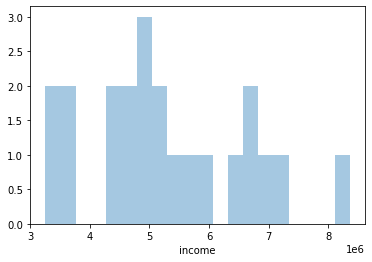

In [30]:
sns.distplot(df['income'][df['is_holiday'] == 1], bins=20, kde=False)

По гистограме видим, что действительно можно сказать, что цены на билеты, а следовательно и прибыль выше среднего. Но так же видим 2 рейса у которых явно низкая прибыль, а билетов продано больше 83% возможно там были скидки на билеты или акции.

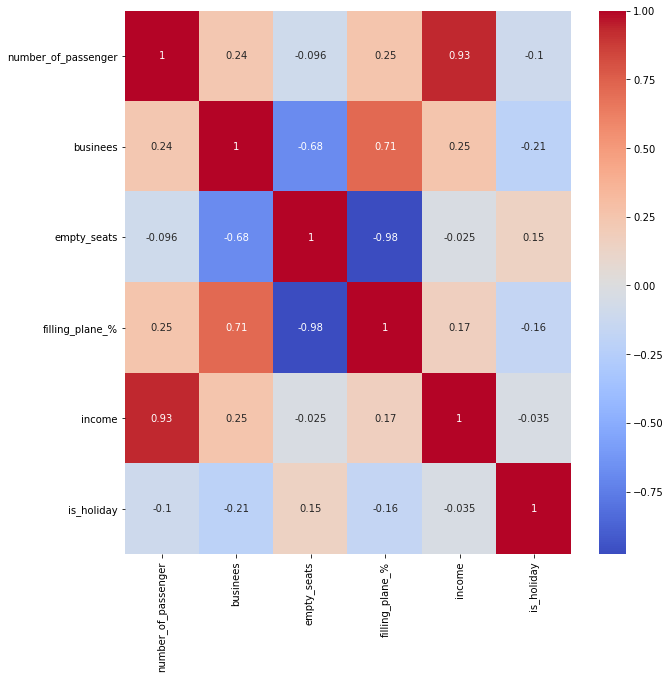

In [31]:
sns.heatmap(df.drop(['flight_id', 'flight_no', 'departure_airport', 'arrival_airport', \
                    'actual_arrival', 'actual_departure', 'model', 'seats_count', \
                    'eco_seats', 'busi_seats', 'time', 'consumption', 'flight_time', 'booking_sum',\
                    'economy'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.gcf().set_size_inches(10, 10)

Матрица корреляции показывает нам, что есть сильная зависимость прибыли от кол-ва пассажиров на борту. Так же видим, что кол-во мест в бизнес-классе тоже достаточно влияет на прибыль. Праздники же почти не влияют на стоимость, как оказалось.

В итоге:
- Больше всего на прибыль влияет заполненость самолета, а так же кол-во проданных билетов в бизнес-класс. Все таки отметим, что прибыль больше в праздники, из-за цен на билеты
- Отрицательно на прибыль сказывается использоавние самолетов большего размера, где возможно использовать самолеты с меньшим кол-вом посадочных мест. И наоборот, где вместо одного рейса самолета с большим посадочных мест используется 2 рейса с меньшим.

Рекомедации:
- Для рейсов до Белгорода 136642 и 136807. Использовать самолеты меньшего размера или объеденить рейсы, но использовать самолет большего размера. Возможно нужно провести оптимизацию следующих рейсов 136609, 136620, 136678, 136767, 136838, 136844, 136887, 136888, 136922, 136936, 136937
- Для рейсов до Москвы 136178, 136250, 136646. Использовать самолеты меньшего размера, например SuperJet, который находится в авиапарке авиакомпании. Возможно стоит поступить так же и с рейсами 136122, 136185, 136202, 136360, 136366, 136420.